In this example, we'll apply a max pooling filter to a simple plane image using Devito.

Firstly, we need to import the required libraries.

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

Then, let's open the image, make it grayscale and convert it to a NumPy array required by the Devito function we'll create in a moment.

In [2]:
image_path = "./plane.png"
img_raw = Image.open(image_path)
img_greysc = img_raw.convert('L')
img_2d = np.array(img_greysc)

This is our image.

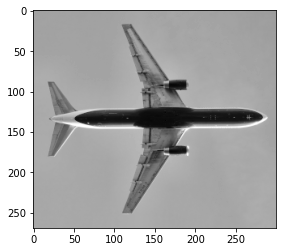

In [3]:
plt.imshow(img_2d, cmap='gray')

Now, let's define a subsampling() function. It will use Devito to generate the optimised code for a subsampling filter of our choice. The return value is a tuple (Operator, NumPy array), where the array stores the result of applying a filter. Calling subsampling() will not run the operator itself just yet, it will only generate and compile a corresponding C code.

In [4]:
from devito import Grid, Function, Operator, dimensions, Eq


def error_check(kernel_size, feature_map, stride, padding):
    if feature_map is None or len(feature_map) == 0:
        raise Exception("Feature map must not be empty")

    if kernel_size is None or len(kernel_size) != 2:
        raise Exception("Kernel size is incorrect")

    if stride is None or len(stride) != 2:
        raise Exception("Stride is incorrect")

    if stride[0] < 1 or stride[1] < 1:
        raise Exception("Stride cannot be less than 1")

    if padding is None or len(padding) != 2:
        raise Exception("Padding is incorrect")

    if padding[0] < 0 or padding[1] < 0:
        raise Exception("Padding cannot be negative")


def subsampling(kernel_size, feature_map, function, stride=(1, 1),
                padding=(0, 0)):
    # All sizes are expressed as (rows, columns).

    error_check(kernel_size, feature_map, stride, padding)

    map_height = len(feature_map) + 2 * padding[0]
    map_width = len(feature_map[0]) + 2 * padding[1]
    kernel_height, kernel_width = kernel_size

    if (map_height - kernel_height) % stride[0] != 0 or \
       (map_width - kernel_width) % stride[1] != 0:
        raise Exception("Stride " + str(stride) + " is not compatible "
                        "with feature map, kernel and padding sizes")

    gridB = Grid(shape=(map_height, map_width))
    B = Function(name='B', grid=gridB, space_order=0)

    a, b = dimensions('a b')
    gridR = Grid(shape=((map_height - kernel_height + stride[0])
                        // stride[0],
                        (map_width - kernel_width + stride[1])
                        // stride[1]),
                 dimensions=(a, b))
    R = Function(name='R', grid=gridR, space_order=0)

    for i in range(padding[0], map_height - padding[0]):
        B.data[i] = \
            np.concatenate(([0] * padding[1],
                            feature_map[i - padding[0]],
                            [0] * padding[1]))

    op = Operator(Eq(R[a, b],
                     function([B[stride[0] * a + i, stride[1] * b + j]
                               for i in range(kernel_height)
                               for j in range(kernel_width)])))
    op.cfunction
    
    return (op, R.data)

Once this is done, we can run a proper max filter. Let's define a kernel (filter) size along with padding first.

In [5]:
# When kernel_size is changed, padding must be changed as well to
# ensure that the Devito and SciPy results are equal.
kernel_size = (5, 5)
padding = (2, 2)

Afterwards, let's call the function and run the operator!

In [6]:
from sympy import Max
op, subsampled_img_2d = subsampling(kernel_size=kernel_size,
                                    feature_map=img_2d,
                                    function=lambda l: Max(*l),
                                    padding=padding)
op.apply()

Operator `Kernel` run in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000258, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Here's our result.

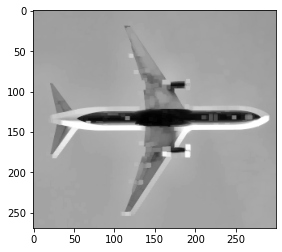

In [7]:
plt.imshow(subsampled_img_2d, cmap='gray')

To make sure the result is correct, we'll use SciPy to apply a maximum filter to the original image.

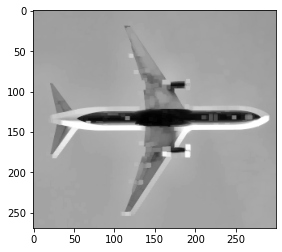

In [8]:
expected_subsampled_img_2d = ndimage.maximum_filter(input=img_2d, size=kernel_size)
plt.imshow(expected_subsampled_img_2d, cmap='gray')

Do the two pictures look the same? This is indeed the case as shown below.

In [9]:
np.array_equal(subsampled_img_2d, expected_subsampled_img_2d)

True

To finish off, let's make a simple performance evaluation.

**Devito:**

In [10]:
from devito import logger
logger.set_log_noperf()
%timeit op.apply()

675 µs ± 8.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**SciPy:**

In [11]:
%timeit ndimage.maximum_filter(input=img_2d, size=kernel_size)

1.5 ms ± 4.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
